In [9]:
import apogee.tools.read as apread
from apogee.tools import bitmask
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
import window as wn
import os
import access_spectrum as acs
import reduce_dataset as rd
import polyfit as pf
import matplotlib
import apogee.spec.plot as splot
# Show plots in notebook
%pylab inline
# Read in red clump sample
data = apread.rcsample()
# Set random seed value
seedval = 1
# Start random seed
np.random.seed(seedval) #original was 17
# Set global plot font preferences
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [18]:
# Choose output directories
direc = './red_clump/pickles/'
pdirec = './red_clump/fitplots/'
rdirec = './red_clump/residual_plots/'

In [3]:
# Load in spectra
# Choose parameter space to slice in, with upper and lower limit
label = 'FE_H'
low = -0.5
up = -0.4
# Choose data file names
specsname = 'specs_{0}_u{1}_d{2}.pkl'.format(label,low,up)
errsname = 'errs_{0}_u{1}_d{2}.pkl'.format(label,low,up)
maskname = 'mask_{0}_u{1}_d{2}.pkl'.format(label,low,up)

sliceinfo = [label,low,up]
# Find data indices corresponding to out slice
sindx = rd.slice_data(data, sliceinfo)
sdata = data[sindx]
# Get set of bitmasks
maskdata = acs.get_spectra_ap(sdata,ext = 3, header = False,indx = 1)
ints = [i for i in range(len(maskdata)) if not isinstance(maskdata[i],np.int16)]
maskdata = maskdata[ints]
maskdata = np.array(list(maskdata),dtype = np.int64)
# Get spectra and spectra uncertainty after ASPCAP pipeline
specs = acs.get_spectra_asp(sdata,header = False)
specs = specs[ints]
errs = acs.get_spectra_asp(sdata,ext = 2, header = False)
errs = errs[ints]

In [4]:
# Find all pixels corresponding to any of the element windows so we can choose to plot those pixel fits
elems = ['Al','Ca','C','Fe','K','Mg','Mn','Na','Ni','N','O','Si','S','Ti','V']
totalw = np.zeros(len(specs[0]))
for elem in elems:
    w = wn.read(elem,dr = 12,apStarWavegrid=False)
    totalw += w

In [11]:
# Find fit residuals
# Set polynomial order
order = 2
# Choose bad pixel mask value
badcombpixmask= bitmask.badpixmask()+2**bitmask.apogee_pixmask_int("SIG_SKYLINE")
# Choose names for saving data files
ressname = 'rcresiduals_order{0}_{1}_u{2}_d{3}.pkl'.format(order,label,low,up)
gname = 'rcgerr_order{0}_{1}_u{2}_d{3}_seed{4}.pkl'.format(order,label,low,up,seedval)
paramname = 'fitparam_{0}_{1}_u{2}_d{3}.pkl'.format(order,label,low,up)
disname = 'discard_rcresiduals_order{0}_{1}_u{2}_d{3}.pkl'.format(order,label,low,up)
failname = 'fails_rcresiduals_order{0}_{1}_u{2}_d{3}.pkl'.format(order,label,low,up)
def rcfitplotname(pix):
    return 'pix{0}fit_order{1}_{2}_u{3}_d{4}.png'.format(pix,order,label,low,up)

# Choose whether to force regeneration of fit data
ngen = False
# Choose whether to generate some fit plots
doplot = True

# If regeneration unecessary and files exist, load them in
if os.path.isfile(direc+ressname) and os.path.isfile(direc+gname) and os.path.isfile(direc+paramname) and os.path.isfile(direc+disname) and ngen:
    ress = acs.pklread(direc+ressname)
    gerr = acs.pklread(direc+gname)

# If regeneration necessary or files don't exist, create them
elif not os.path.isfile(direc+ressname) or not os.path.isfile(direc+gname) or not os.path.isfile(direc+paramname) or not os.path.isfile(direc+disname) or not ngen:
    ps = []
    ress = []
    gerr = []
    discard = []
    fails = []
    for pix in range(len(specs[0])):
        # Find bad pixels
        mask,badspec = rd.pixmask_find(maskdata,pix,bitval = badcombpixmask)
        
        # Apply mask
        mdata = sdata[mask]
        mspecs = specs[mask]
        merrs = errs[mask]
        
        # Note how many spectra were discarded in the masking process
        discard.append('{0} of {1}'.format(len(sdata)-len(mask[0]),len(sdata)))
        
        # Create arrays in the independent variables
        Teff = np.arange(min(mdata['TEFF']),max(mdata['TEFF']))
        logg = np.arange(min(mdata['LOGG']),max(mdata['LOGG']),((max(mdata['LOGG']-min(mdata['LOGG'])))/len(Teff)))
        metals = np.arange(min(mdata['METALS']),max(mdata['METALS']),((max(mdata['METALS']-min(mdata['METALS'])))/len(Teff)))
        
        # Set up zero arrays to hold residuals so missing stars will vanish after weighting
        res = np.zeros(len(specs))
        erarr = np.zeros(len(specs))
        
        try: 
            # Find the fit parameters
            p = pf.regfit((mdata['TEFF'],mdata['LOGG'],mdata['FE_H']),mspecs[:,pix],err = merrs[:,pix],order = order)
            ps.append(p)
            
            # Calculate residuals from the fit
            res[mask] = mspecs[:,pix] - pf.poly(p,(mdata['TEFF'],mdata['LOGG'],mdata['METALS']),order = order)
            ress.append(res)
            
            # Find measurement noise
            for mval in mask[0]:
                erarr[mask[0][mval]] = np.random.normal(0,errs[mval][pix])
            gerr.append(erarr)
            
            if totalw[pix] != 0 and doplot:
                # Find points with/out high uncertainty that are not zero
                # This is to avoid large errorbars and reduce the plotting to a manageable scale
                rpl = np.where((merrs[:,pix] > 0.1) & (mspecs[:,pix] != 0))
                pl = np.where((merrs[:,pix] < 0.1) & (mspecs[:,pix] != 0))
                
                # Start figure
                plt.figure(figsize = (12,10))
                
                # First column - Temperature and flux uncertainty
                # Fit vs Temperature
                plt.subplot2grid((3,3),(0,0))
                plt.errorbar(mdata['TEFF'][pl],mspecs[:,pix][pl],yerr = merrs[:,pix][pl],fmt='.')
                plt.plot(Teff,pf.poly(p,(Teff,logg,metals),order = O),linewidth = 3)
                plt.plot(mdata['TEFF'][rpl],mspecs[:,pix][rpl],'.')
                plt.xlabel('T_EFF')
                plt.ylabel('Pixel {0}'.format(pix))
                # Residuals vs Temperature
                plt.subplot2grid((3,3),(1,0))
                plt.plot(mdata['TEFF'][pl],res[pl],'.')
                plt.xlabel('T_EFF')
                plt.ylabel('Fit residuals')
                # Residuals vs flux uncertainty
                plt.subplot2grid((3,3),(2,0))
                plt.semilogx(errs[:,pix][pl],res[pl],'.')
                plt.xlabel('Uncertainty in Pixel {0}'.format(pix))
                plt.ylabel('Fit residuals')
                
                # Second column - surface gravity
                # Fit vs surface gravity
                plt.subplot2grid((3,3),(0,1))
                plt.errorbar(mdata['LOGG'][pl],mspecs[:,pix][pl],yerr = merrs[:,pix][pl],fmt='.')
                plt.plot(logg,pf.poly(p,(Teff,logg,metals),order = O),linewidth = 3)
                plt.plot(mdata['LOGG'][rpl],mspecs[:,pix][rpl],'.')
                plt.xlabel('LOG(G)')
                plt.ylabel('Pixel {0}'.format(pix))
                # Residuals vs surface gravity
                plt.subplot2grid((3,3),(1,1))
                plt.plot(mdata['LOGG'][pl],res[pl],'.')
                plt.xlabel('LOG(G)')
                plt.ylabel('Fit residuals')
                
                # Third column - metals
                # Fit vs metals
                plt.subplot2grid((3,3),(0,2))
                plt.errorbar(mdata['METALS'][pl],mspecs[:,pix][pl],yerr = merrs[:,pix][pl],fmt='.')
                plt.plot(metals,pf.poly(p,(Teff,logg,metals),order = O),linewidth = 3)
                plt.plot(mdata['METALS'][rpl],mspecs[:,pix][rpl],'.')
                plt.xlabel('Metallicity')
                plt.ylabel('Pixel {0}'.format(pix))
                # Residuals vs metals
                plt.subplot2grid((3,3),(1,2))
                plt.plot(mdata['METALS'][pl],res[pl],'.')
                plt.xlabel('Metallicity')
                plt.ylabel('Fit residuals')
                plt.tight_layout()
                
                # Save and close figure
                print pdirec+rcfitplotname(pix)
                plt.savefig(pdirec+rcfitplotname(pix))
                plt.close()

        except LinAlgError:
            fails.append('Failure at pixel {0}'.format(pix))
            continue
    # Save to files
    ress = np.array(ress)
    gerr = np.array(gerr)
    acs.pklwrite(direc+failname,fails)
    acs.pklwrite(direc+disname,discard)
    acs.pklwrite(direc+paramname,ps)
    acs.pklwrite(direc+ressname,ress)
    acs.pklwrite(direc+gname,gerr)

./red_clump/fitplots/pix0fit_order2_FE_H_u-0.5_d-0.4.png
./red_clump/fitplots/pix1fit_order2_FE_H_u-0.5_d-0.4.png
./red_clump/fitplots/pix2fit_order2_FE_H_u-0.5_d-0.4.png
./red_clump/fitplots/pix5fit_order2_FE_H_u-0.5_d-0.4.png
./red_clump/fitplots/pix13fit_order2_FE_H_u-0.5_d-0.4.png
./red_clump/fitplots/pix15fit_order2_FE_H_u-0.5_d-0.4.png
./red_clump/fitplots/pix16fit_order2_FE_H_u-0.5_d-0.4.png
./red_clump/fitplots/pix17fit_order2_FE_H_u-0.5_d-0.4.png
./red_clump/fitplots/pix18fit_order2_FE_H_u-0.5_d-0.4.png
./red_clump/fitplots/pix19fit_order2_FE_H_u-0.5_d-0.4.png
./red_clump/fitplots/pix20fit_order2_FE_H_u-0.5_d-0.4.png
./red_clump/fitplots/pix21fit_order2_FE_H_u-0.5_d-0.4.png
./red_clump/fitplots/pix22fit_order2_FE_H_u-0.5_d-0.4.png
./red_clump/fitplots/pix23fit_order2_FE_H_u-0.5_d-0.4.png
./red_clump/fitplots/pix24fit_order2_FE_H_u-0.5_d-0.4.png
./red_clump/fitplots/pix25fit_order2_FE_H_u-0.5_d-0.4.png
./red_clump/fitplots/pix26fit_order2_FE_H_u-0.5_d-0.4.png
./red_clump/fitplo

In [16]:
# Calculate weighted residual sum for each element
elems = ['Al','Ca','C','Fe','K','Mg','Mn','Na','Ni','N','O','Si','S','Ti','V']
ngen = True

# Record pixels corresponding to the different elements in a dictionary
elemwindow = {}
elemname = 'pixelwindows_order{0}_{1}_u{2}_d{3}.pkl'.format(order,label,low,up)

def rcresid_elemname(elem):
    return '{0}_residuals_order{1}_{2}_u{3}_d{4}.pkl'.format(elem,order,label,low,up)

def rcgerr_elemname(elem):
    return '{0}_rcgerr_order{1}_{2}_u{3}_d{4}_seed{5}.pkl'.format(elem,O,label,low,up,seedval)

# Cycle through all elements, checking for weighted residual files, creating them if necessary
for elem in elems:
    if os.path.isfile(direc+rcresid_elemname(elem)) and os.path.isfile(direc+rcgerr_elemname(elem)) and ngen:
        continue
    elif not os.path.isfile(direc+rcresid_elemname(elem)) or not os.path.isfile(direc+rcgerr_elemname(elem)) or not ngen:
        # Read in window associated with the element
        w = wn.read(elem,dr = 12,apStarWavegrid=False)
        th = wn.tophat(elem,dr=12,apStarWavegrid=False)
        # Record which pixels are relevant for this element
        elemwindow[elem] = np.where(th==True)[0]
        # Normalized weights
        nw = pf.normweights(w)[th]
        # Prepare lists to hold the weighted residual for each star for this element
        resids = []
        gresid = []
        for star in range(len(ress[0])):
            # Create weighted residual sum for each star
            resids.append(pf.genresidual(nw,ress[:,star][th]))
            gresid.append(pf.genresidual(nw,gerr[:,star][th]))
        resids = np.array(resids)
        gresid = np.array(gresid)
        # Save weighted residuals for all stars for this element
        acs.pklwrite(direc+rcresid_elemname(elem),resids)
        acs.pklwrite(direc+rcgerr_elemname(elem),gresid)

# Save pixel-element information if necessary
if not os.path.isfile(direc+elemname) or not ngen:
    acs.pklwrite(direc+elemname,elemwindow)

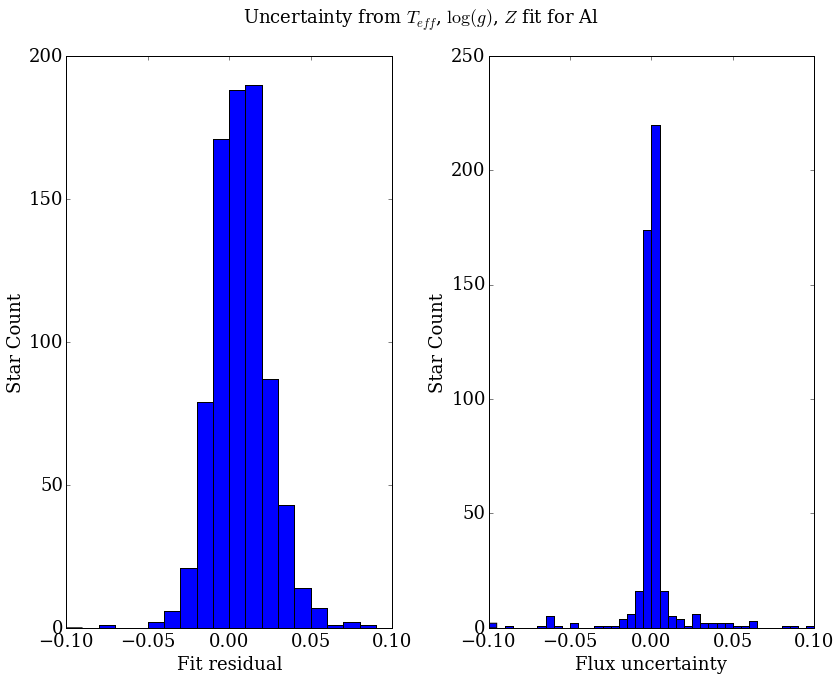

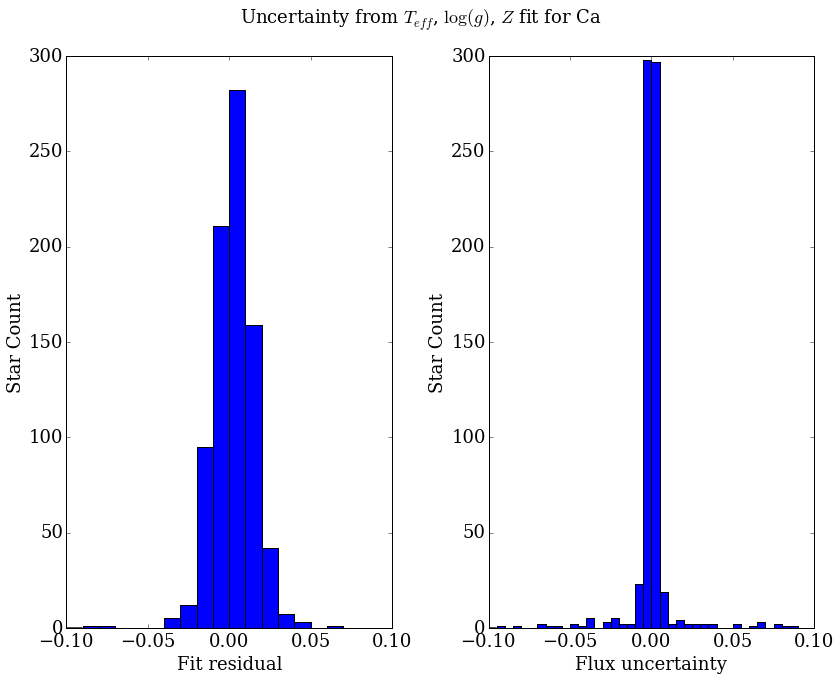

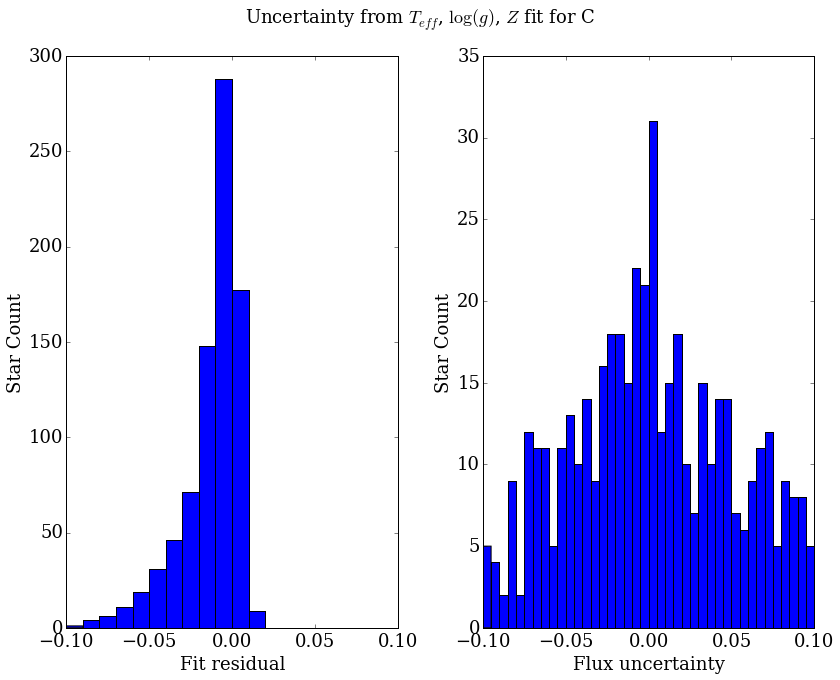

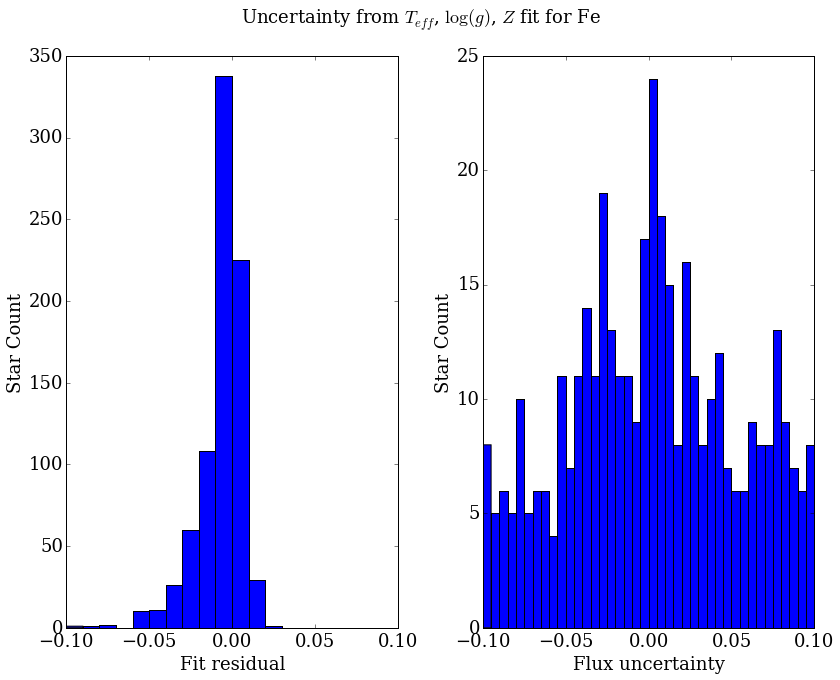

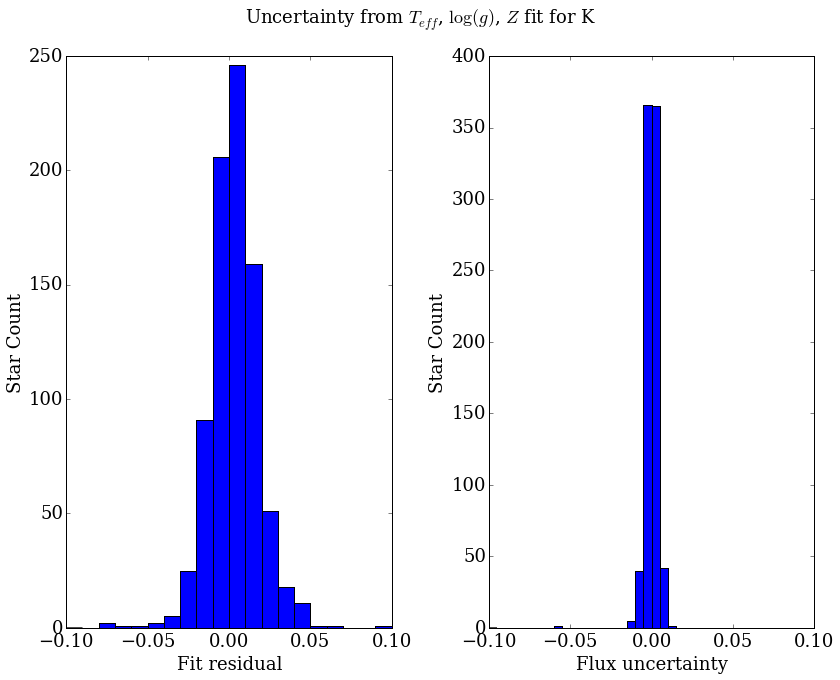

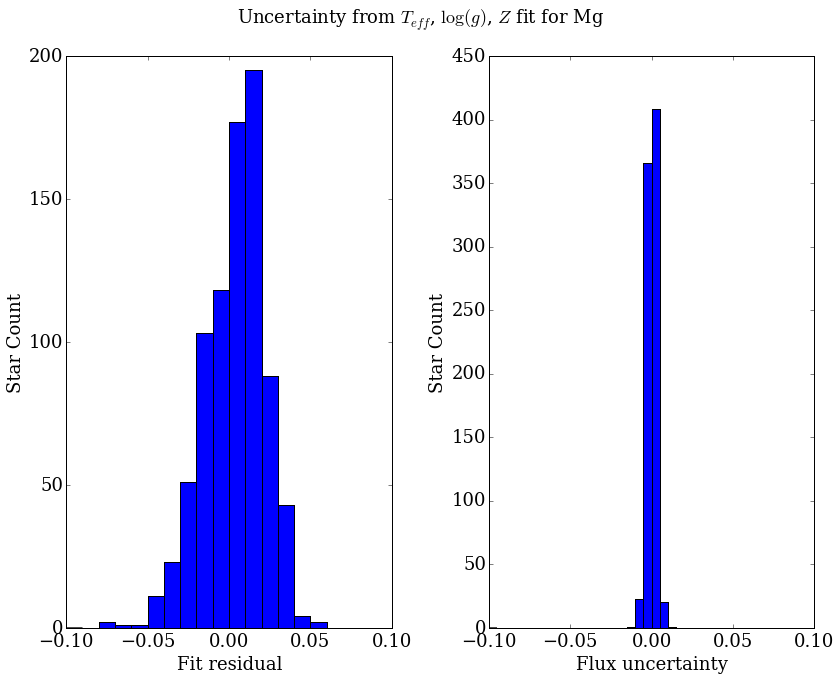

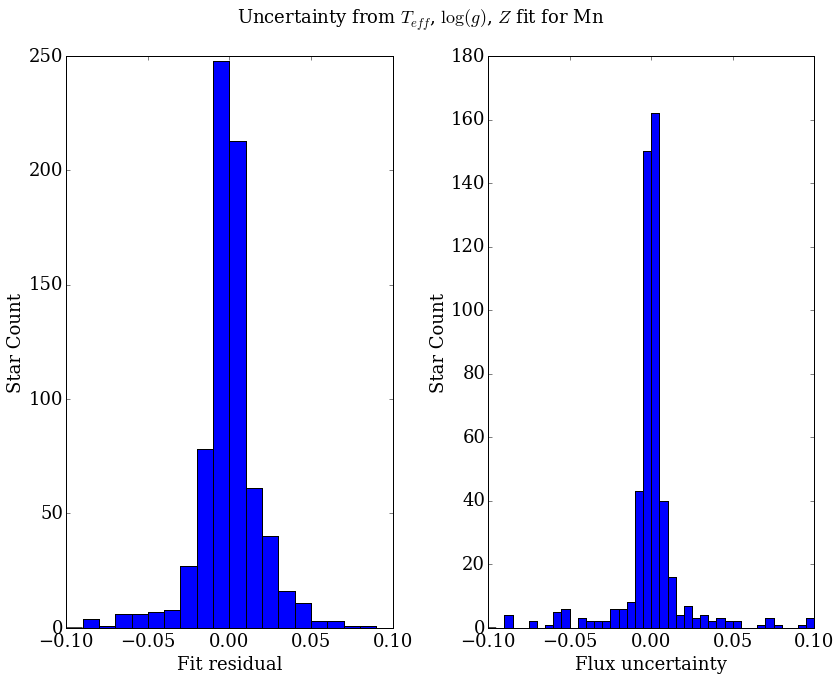

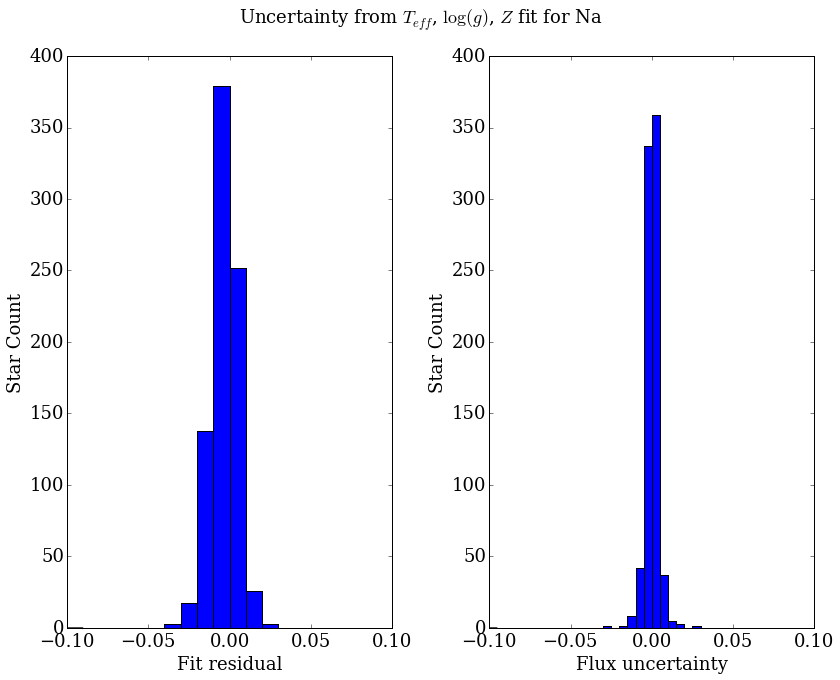

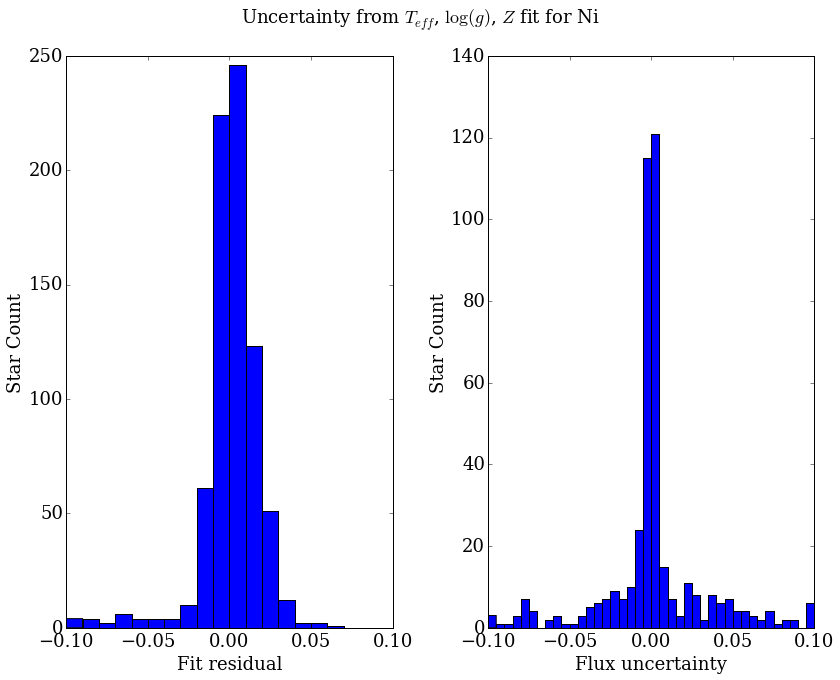

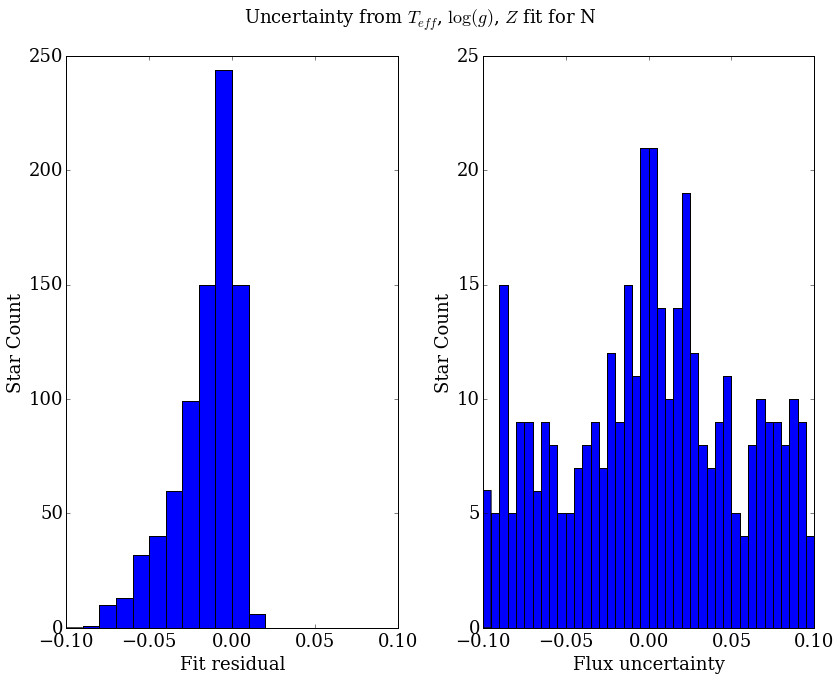

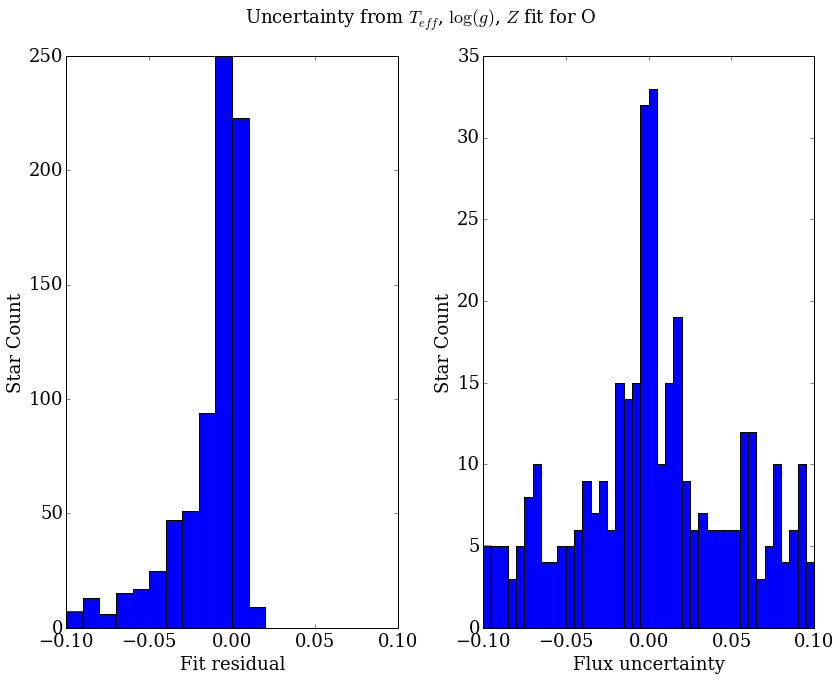

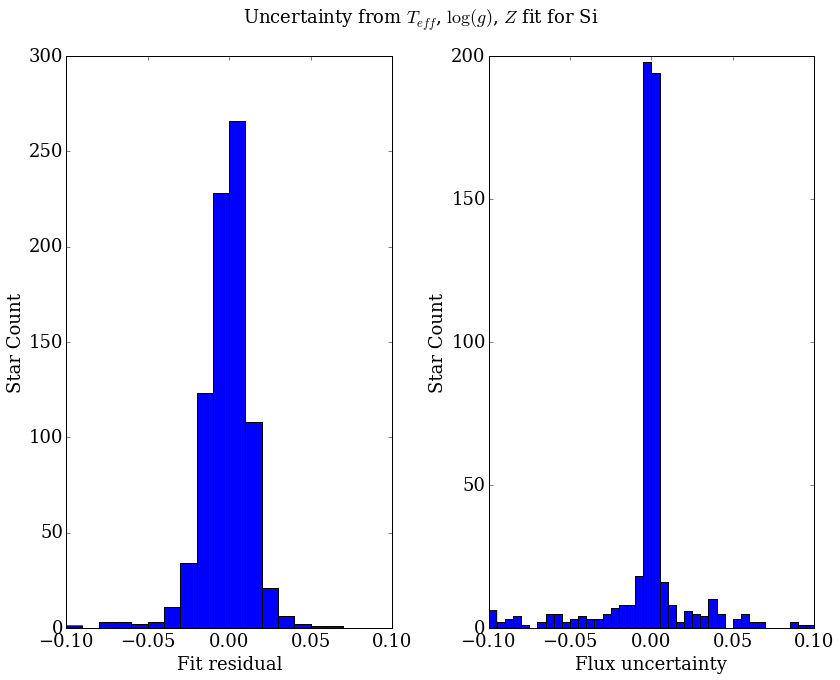

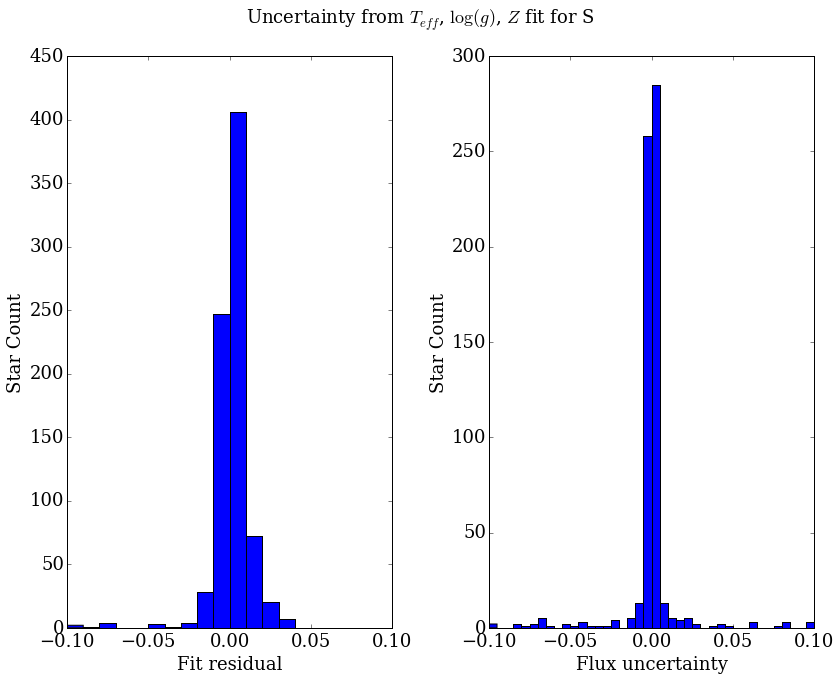

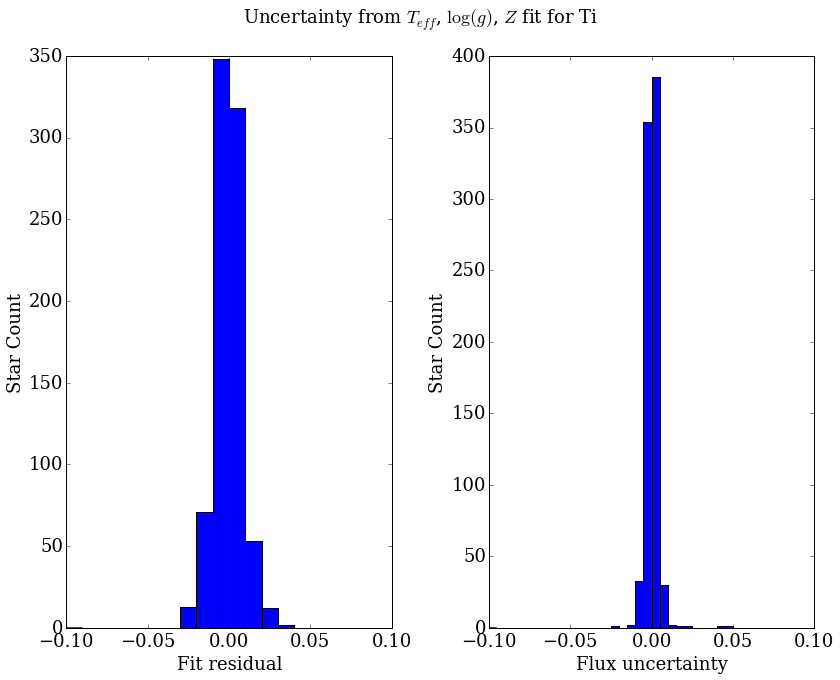

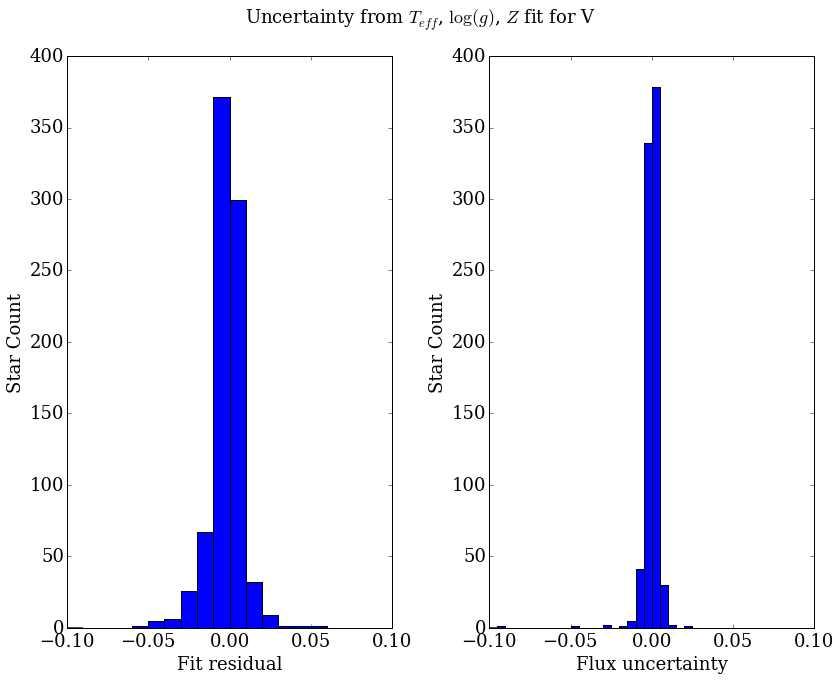

In [19]:
# Plot residuals for each element
doplot = True

# Name the plot for each element
def rcoutplotname(elem):
    return '{0}_residuals_order{1}_{2}_u{3}_d{4}_seed{5}.png'.format(elem,order,label,low,up,seedval)

# Make residual plots
if doplot:
    for elem in elems:
        resids = acs.pklread(direc+rcresid_elemname(elem))
        gresid = acs.pklread(direc+rcgerr_elemname(elem))
        plt.figure(figsize = (12,10))
        allow = np.where(np.isnan(gresid) == False)
        
        # Plot residual histogram
        plt.subplot(121)
        plt.hist(resids[allow],bins = 20,range = (-0.1,0.1),stacked=True)
        plt.xlim(-0.1,0.1)
        plt.xlabel('Fit residual')
        plt.ylabel('Star Count')
        plt.suptitle('Uncertainty from $T_{eff}$, $\log(g)$, $Z$ fit for '+elem)
        
        # Plot flux uncertainty historgram
        plt.subplot(122)
        plt.hist(gresid[allow],bins = 40,range = (-0.1,0.1),stacked=True)
        plt.xlabel('Flux uncertainty'.format(elem))
        plt.ylabel('Star Count')
        plt.xlim(-0.1,0.1)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.savefig(rdirec+rcoutplotname(elem))

In [46]:
from read_clusterdata import read_caldata
dat = read_caldata()

In [47]:
dat['APOGEE_ID'] = dat['ID']

In [48]:
specsfile = './open_clusters/specs_cdata.pkl'
errsfile = './open_clusters/errs_cdata.pkl'
if os.path.isfile(specsfile):
    specs,ind = acs.pklread(specsfile)
    errs,ind = acs.pklread(errsfile)
    print 'Missing {0} stars'.format(len(ind))
else:
    specdata = acs.get_spectra_asp(dat,header = False)
    errdata= acs.get_spectra_asp(dat,ext = 2, header = False)
    acs.pklwrite(specsfile,specdata)
    acs.pklwrite(errsfile,errdata)
    specs,ind = specdata
    errs,ind = errdata  

File aspcapStar-r5-v603-2M03403073+2429143.fits does not appear to exist on the server ...
File aspcapStar-r5-v603-2M03405126+2335544.fits does not appear to exist on the server ...
File aspcapStar-r5-v603-2M03413958+2345471.fits does not appear to exist on the server ...
File aspcapStar-r5-v603-2M03415366+2327287.fits does not appear to exist on the server ...
File aspcapStar-r5-v603-2M03415868+2342263.fits does not appear to exist on the server ...
File aspcapStar-r5-v603-2M03420383+2442454.fits does not appear to exist on the server ...
File aspcapStar-r5-v603-2M03422154+2439527.fits does not appear to exist on the server ...
File aspcapStar-r5-v603-2M03422760+2502492.fits does not appear to exist on the server ...
File aspcapStar-r5-v603-2M03424189+2411583.fits does not appear to exist on the server ...
File aspcapStar-r5-v603-2M03432662+2459395.fits does not appear to exist on the server ...
File aspcapStar-r5-v603-2M03433660+2327141.fits does not appear to exist on the server ...

In [49]:
O = 2
dat = dat[ind]
Tkeep = np.where(dat['TEFF']!=0)
dat = dat[Tkeep]
specs = specs[Tkeep]
errs = errs[Tkeep]
np.unique(dat['CLUSTER'])

M107
M13
M15
M2
M3
M5
M53
M67
M71
M92
N188


In [50]:
# Pick cluster
cluster = 'M13'
Ckeep = np.where(dat['CLUSTER']==cluster)
dat = dat[Ckeep]
specs = specs[Ckeep]
errs = errs[Ckeep]

In [51]:
# Find fit residuals
direc = './open_clusters/pickles/'
pdirec = './open_clusters/fitplots/'
ressname = 'cresiduals_order{0}.pkl'.format(O)
gname = 'cgerr_order{0}.pkl'.format(O)
ngen = False
if os.path.isfile(direc+ressname) and ngen:
    ress = acs.pklread(direc+ressname)
elif not os.path.isfile(direc+ressname) or not ngen:
    ps = []
    ress = []
    discard = []
    gerr = []
    for pix in range(len(specs[0])):
        mask,badspec = rd.pixmask_find(maskdata,pix,bitval = badcombpixmask)
        mdata = dat[mask]
        mspecs = specs[mask]
        merrs = errs[mask]
        Teff = np.arange(min(mdata['TEFF']),max(mdata['TEFF']))
        discard.append('{0} of {1}'.format(len(sdata)-len(mask[0]),len(sdata)))
        res = np.zeros(len(specs))
        erarr = np.zeros(len(specs))
        try:
            p = pf.regfit(mdata['TEFF'],mspecs[:,pix],err = merrs[:,pix],order = O)
            ps.append(p)
            res = specs[:,pix] - pf.poly(p,mdata['TEFF'],order = O)
            ress.append(res)
            if totalw[pix] != 0:
                pl = np.where((merrs[:,pix] < 0.1) & (mspecs[:,pix] != 0))
                rpl = np.where((merrs[:,pix] > 0.1) & (mspecs[:,pix] != 0))
                plt.figure(figsize = (12,10))
                plt.subplot2grid((3,1),(0,0))
                plt.errorbar(mdata['TEFF'][pl],mspecs[:,pix][pl],yerr = merrs[:,pix][pl],fmt='.')
                plt.plot(Teff,pf.poly(p,Teff,order = O),linewidth = 3)
                plt.plot(mdata['TEFF'][rpl],mspecs[:,pix][rpl],'.')
                plt.xlabel('T_EFF')
                plt.ylabel('Pixel {0}'.format(pix))
                plt.subplot2grid((3,3),(1,0))
                plt.plot(mdata['TEFF'][pl],res[pl],'.')
                plt.xlabel('T_EFF')
                plt.ylabel('Fit residuals')
                plt.subplot2grid((3,3),(2,0))
                plt.semilogx(errs[:,pix][pl],res[pl],'.')
                plt.xlabel('Uncertainty in Pixel {0}'.format(pix))
                plt.ylabel('Fit residuals')
                print pdirec+'pix{0}fit_order{1}_{2}_u{3}_d{4}.png'.format(pix,O,label,low,up)
                plt.savefig(pdirec+'pix{0}fit_order{1}_{2}_u{3}_d{4}.png'.format(pix,O,label,low,up))
                plt.close()
        except LinAlgError:
            continue
        for mval in mask[0]:
            erarr[mask[0][mval]] = np.random.normal(0,errs[mval][pix])
        gerr.append(erarr)
    ress = np.array(ress)
    gerr = np.array(gerr)
    dfile = open(direc+'dis_'+ressname.split('.pkl')[0]+'.txt','wb')
    dfile.write("\n".join(discard))
    acs.pklwrite(direc+ressname,ress) 
    acs.pklwrite(direc+gname,gerr)

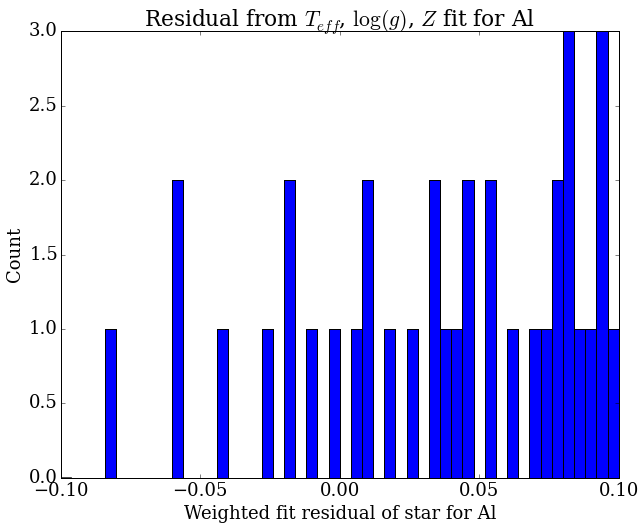

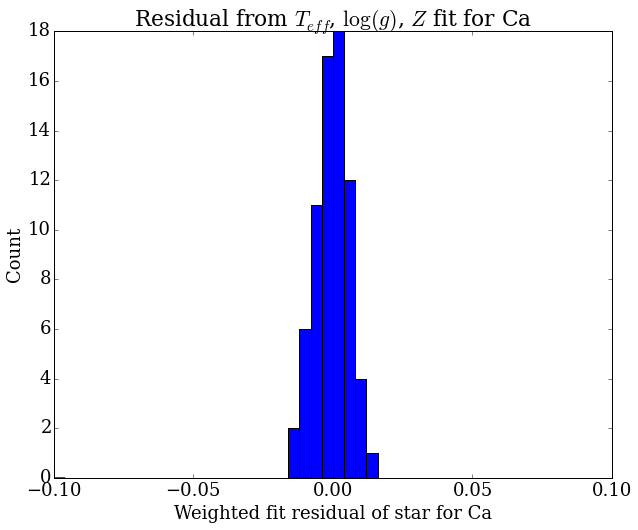

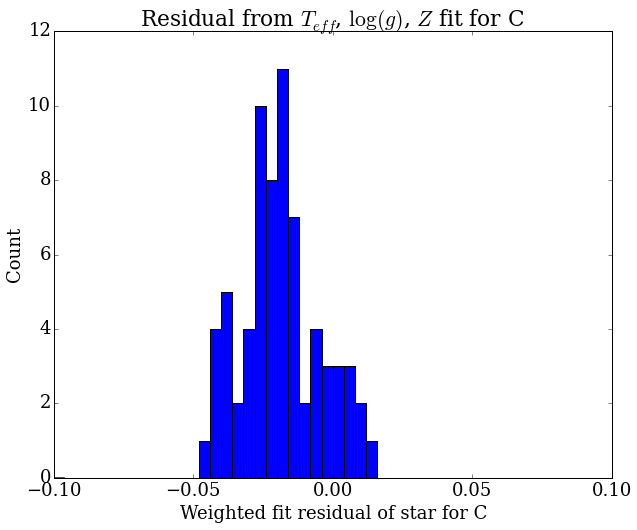

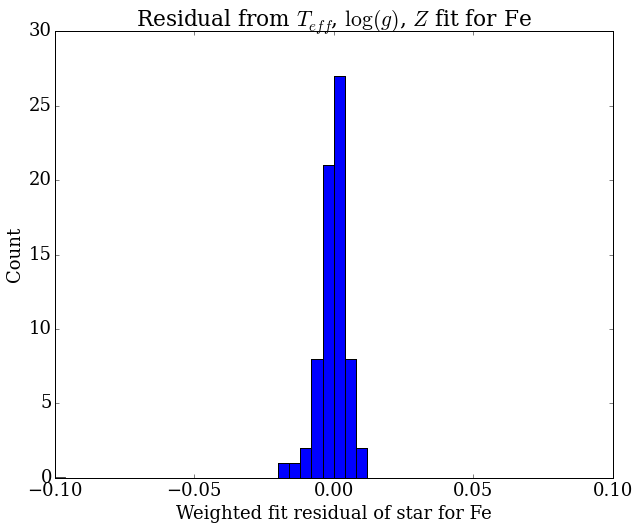

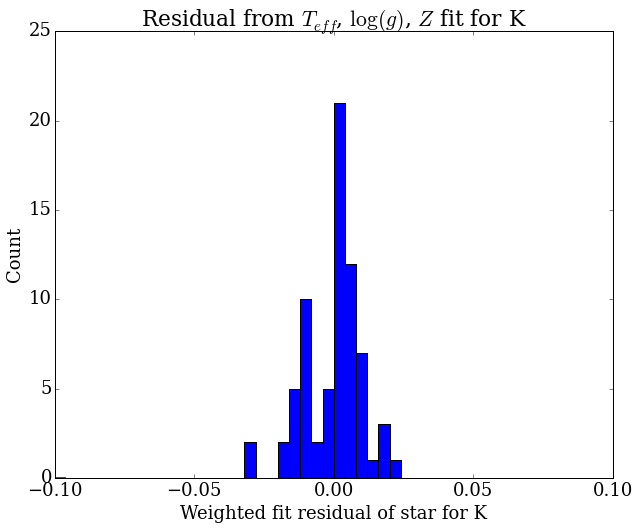

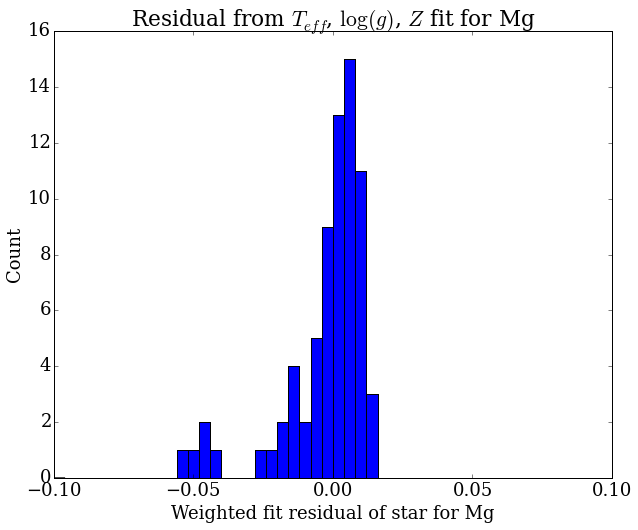

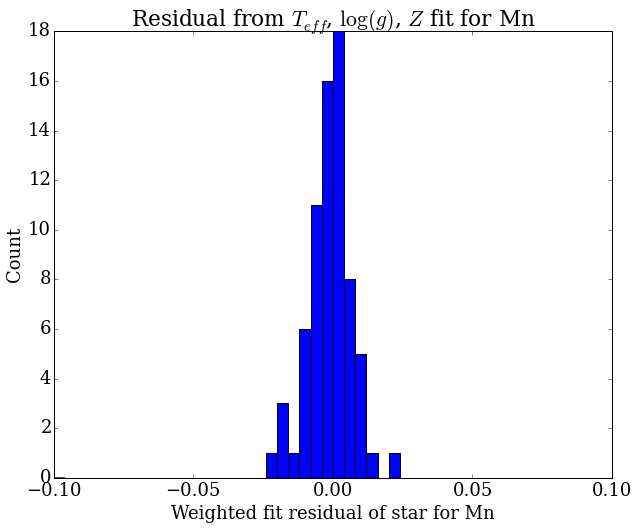

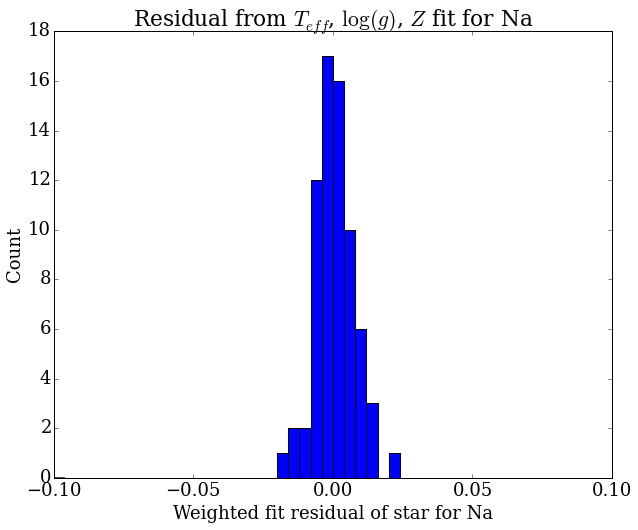

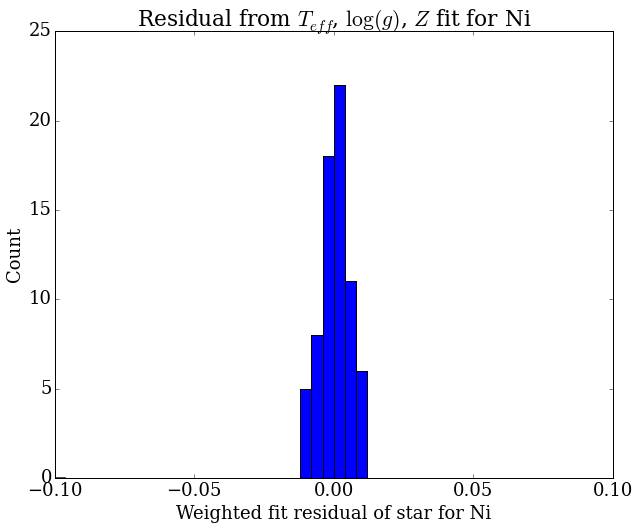

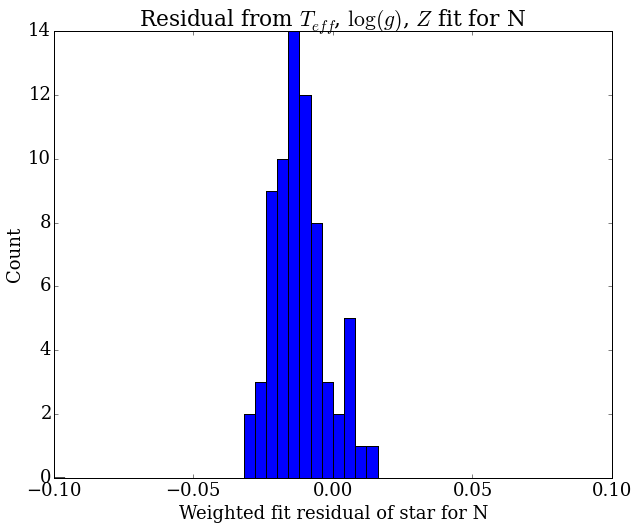

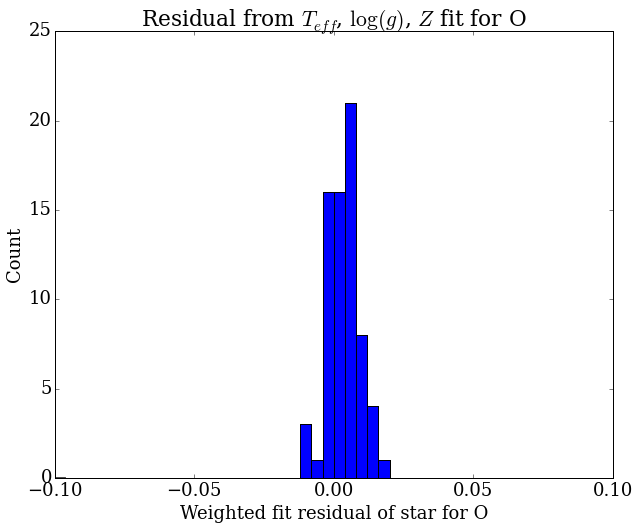

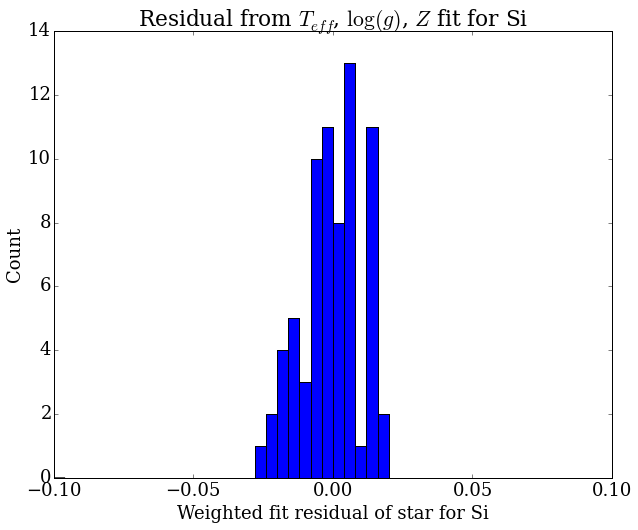

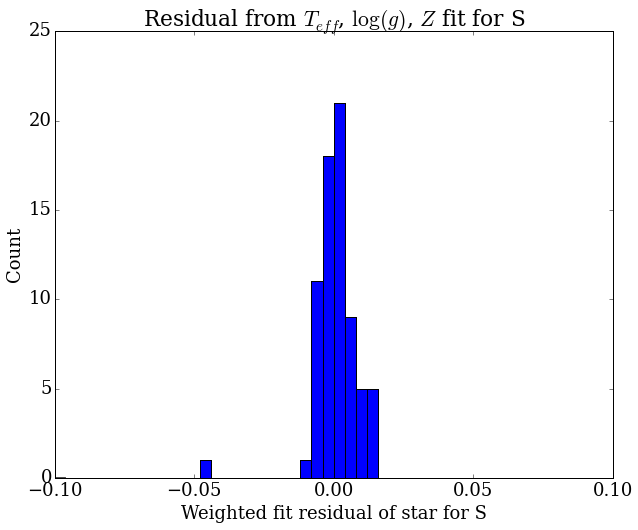

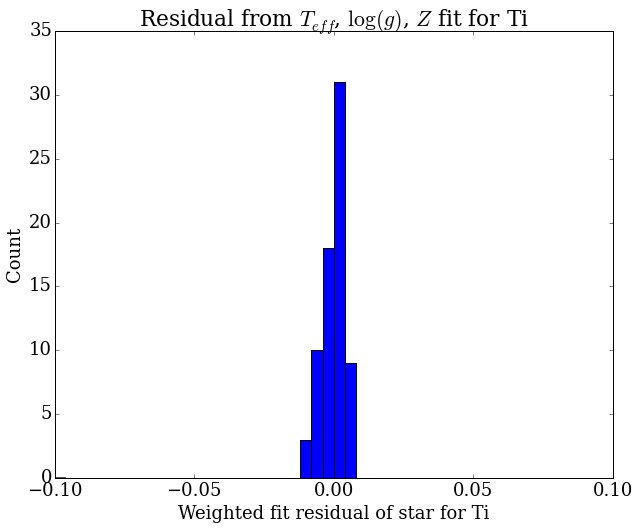

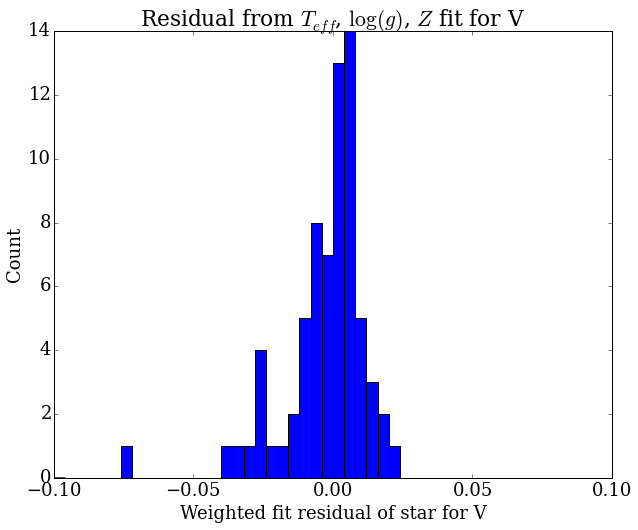

In [53]:
elems = ['Al','Ca','C','Fe','K','Mg','Mn','Na','Ni','N','O','Si','S','Ti','V']
pdirec = './open_clusters/residual_plots/'
for elem in elems:
    w = wn.read(elem,dr = 12,apStarWavegrid=False)
    th = wn.tophat(elem,dr=12,apStarWavegrid=False)
    th = np.where(th == True)
    nw = pf.normweights(w)[th]
    resids = []
    for star in range(len(ress[0])):
        resids.append(pf.genresidual(nw,ress[:,star][th]))
    acs.pklwrite(direc+'{0}_cresiduals{1}_order{2}.pkl'.format(elem,cluster,O),resids)
    plt.figure(figsize = (10,8))
    plt.hist(resids,bins = 50,range=(-0.1,0.1))
    plt.xlim(-0.1,0.1)
    plt.xlabel('Weighted fit residual of star for {0}'.format(elem))
    plt.ylabel('Count')
    plt.title('Residual from $T_{eff}$, $\log(g)$, $Z$ fit for '+elem)
    plt.savefig(pdirec+'{0}_cresiduals{1}_order{2}.png'.format(elem,cluster,O))